In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath('../../..'))

# load the modules
from fridom.ShallowWater.ModelSettings import ModelSettings
from fridom.ShallowWater.Grid import Grid
from fridom.ShallowWater.InitialConditions import Random, SingleWave, Jet
from fridom.ShallowWater.Model import Model
from fridom.ShallowWater.Plot import Plot
from fridom.ShallowWater.Diagnostics.LESFilter import LESFilter
from fridom.ShallowWater.ModelPlotter import ModelPlotter
from fridom.ShallowWater.State import State
from fridom.Framework.ModelBase import ModelBase

In [2]:
plot = lambda z: Plot(z.h)(z)
fac = 9
reso = 2**fac
dt = 2**(-fac)
mset = ModelSettings(N=[reso, reso], dt=dt, Ro=0.3)
grid = Grid(mset)
z_ini = Random(mset, grid, seed=0)
model = Model(mset, grid)
model.z = z_ini
model.run(runlen=5)

100%|██████████| 2560/2560 [00:12<00:00, 200.12it/s]


In [3]:
zf = model.z.copy()
les = LESFilter(mset, grid, kmax=20)

les.diagnose_energy(zf)


======================== ENERGY DIAGNOSTICS ========================
            Resolved     |      Unresolved     |    Total
Pot:  1.98e+01 (100.00%) |  5.36e-04 (  0.00%) |  1.976e+01
Kin:  5.34e-01 ( 94.45%) |  3.14e-02 (  5.55%) |  5.655e-01
Tot:  2.03e+01 ( 99.84%) |  3.19e-02 (  0.16%) |  2.033e+01
------------------------- ENERGY TRANSFER --------------------------
            Leonard      |         Clark       |         Reynolds
Pot: -4.68e-18 (  0.00%) | -3.53e-04 ( 97.49%) | -9.071e-06 (  2.51%)
Kin: -3.04e-04 (-48.28%) | -9.01e-03 (-1431.68%) |  9.947e-03 (1579.96%)
Tot: -3.04e-04 (-113.48%) | -9.37e-03 (-3496.47%) |  9.937e-03 (3709.94%)


In [4]:
model2 = Model(mset, grid)
model2.z = z_ini.copy()
e_totf = []
e_tot  = []
e_totr = []

e_tot_ten = []

integrate = lambda f: np.sum(f) * mset.dx * mset.dy


model2.mset.enable_tqdm = False
for _ in range(1280):
    model2.step()
    e_totf.append(integrate(model2.z.etot().cpu()))
    e_tot.append(integrate(les.filter_state(model2.z).etot().cpu()))
    e_totr.append(e_totf[-1] - e_tot[-1])

    etot_l = integrate(les.leonard_etot(model2.z).cpu())
    etot_c = integrate(les.clark_etot(model2.z).cpu())
    etot_r = integrate(les.reynolds_etot(model2.z).cpu())
    e_tot_ten.append(etot_l + etot_c + etot_r)


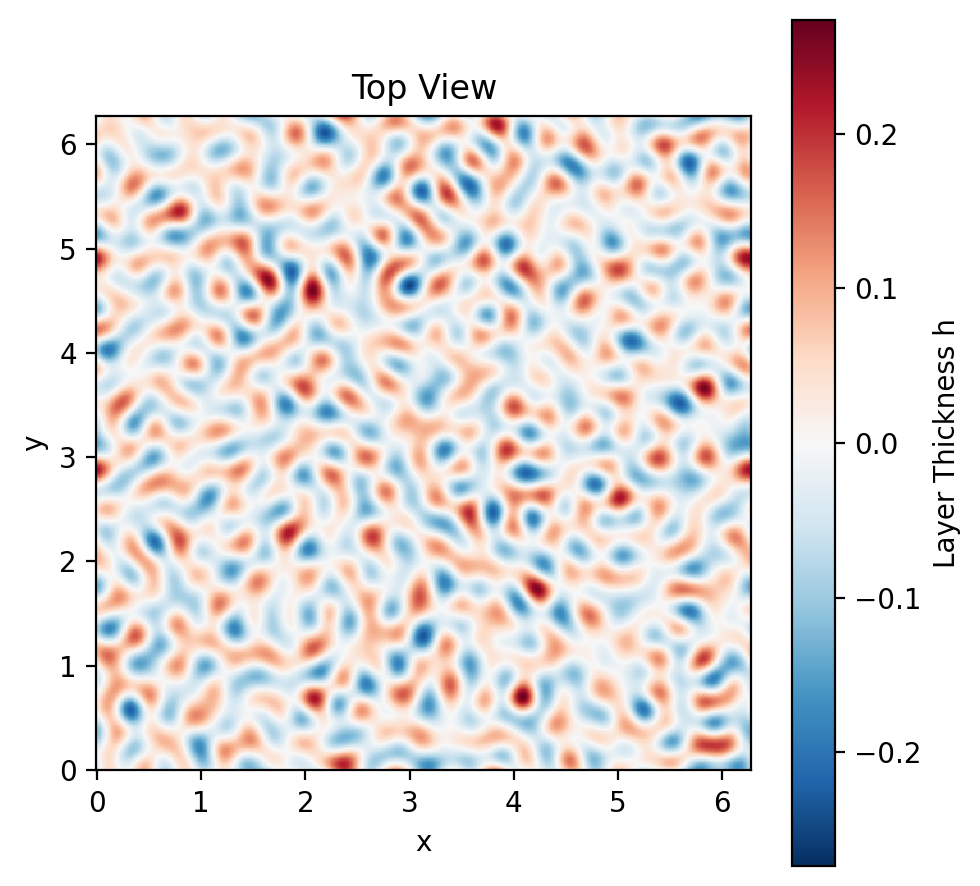

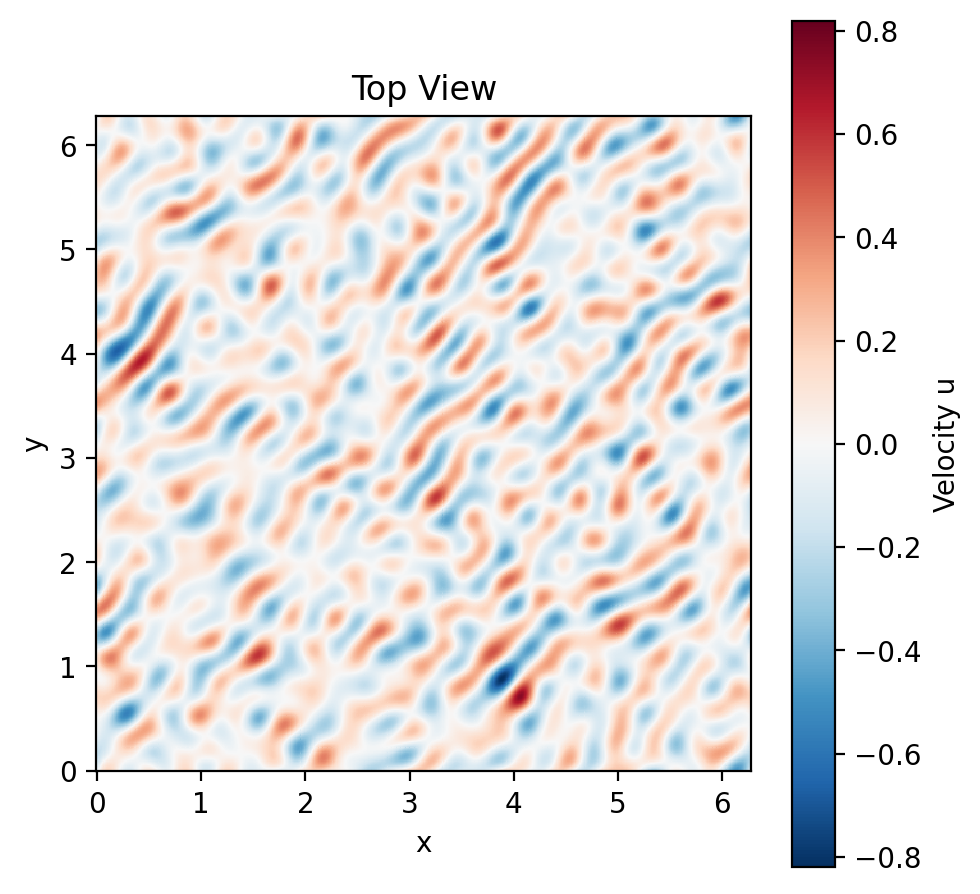

In [4]:
z_test = z_ini.copy()
model.reset()
model.z = z_test.copy()
model.step()
dz_true = les.filter_state(model.dz)

dz_test = z_test * 0

H = mset.csqr + mset.Ro * les.filter_field(z_test.h)
h_fil = les.filter_field(z_test.h)
U = les.filter_field(z_test.u)
V = les.filter_field(z_test.v)

dz_test.h = - mset.Ro * (les.differentiate(U*h_fil, axis=0) + les.differentiate(V*h_fil, axis=1)) - mset.csqr * (les.differentiate(U, axis=0) + les.differentiate(V, axis=1))
dz_test.u = - mset.Ro * (U*les.differentiate(U, axis=0) + V*les.differentiate(U, axis=1)) - les.differentiate(H, axis=0) / mset.Ro + mset.f0 * V
dz_test.v = - mset.Ro * (U*les.differentiate(V, axis=0) + V*les.differentiate(V, axis=1)) - les.differentiate(H, axis=1) / mset.Ro - mset.f0 * U

dz_correct = (les.leonard_correction(z_test) + les.clark_correction(z_test) + les.reynolds_correction(z_test)) * mset.Ro

Plot(dz_true.h)()
Plot(dz_test.h - dz_correct.h)()

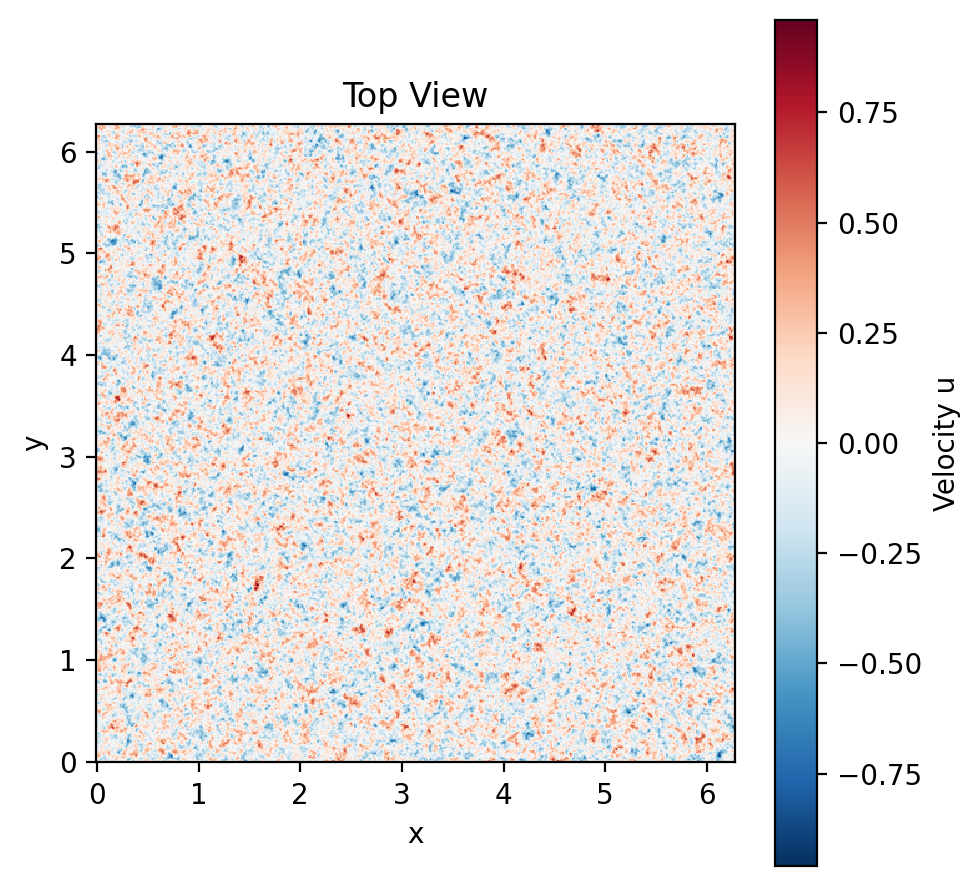

In [5]:
dh = - mset.csqr * (les.differentiate(z_test.u, axis=0) + les.differentiate(z_test.v, axis=1))
dh2 = -mset.csqr * (z_test.u.diff_backward(axis=0) + z_test.v.diff_backward(axis=1))
# dh -= mset.Ro * (les.differentiate(z_test.u * z_test.h, axis=0) + les.differentiate(z_test.v * z_test.h, axis=1))

model.reset()
mset.enable_nonlinear = False
model.z = z_test.copy()
model.step()
dz_test = model.dz

Plot(dh2)()

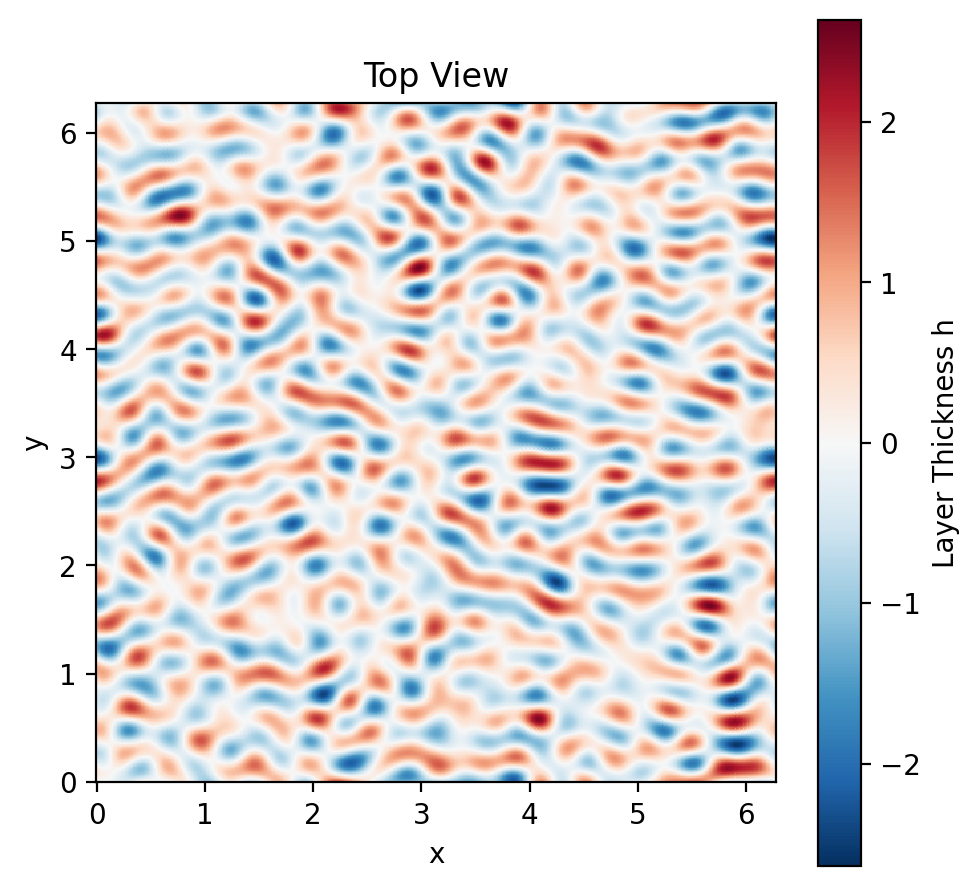

In [25]:
h = dz_true.h
dh = h.diff_forward(axis=1)
dh2 = les.differentiate(h, axis=1, order=1)
Plot(dh2)()

In [9]:
print(np.sum(les.reynolds_epot(zf)))

-0.13442347985353365


In [25]:
zc = les.clark_correction(zf)
C_H = zc.h * mset.Ro
H = les.filter_field(z.h) * mset.Ro
np.sum(H * C_H)

array(-1.27457897)

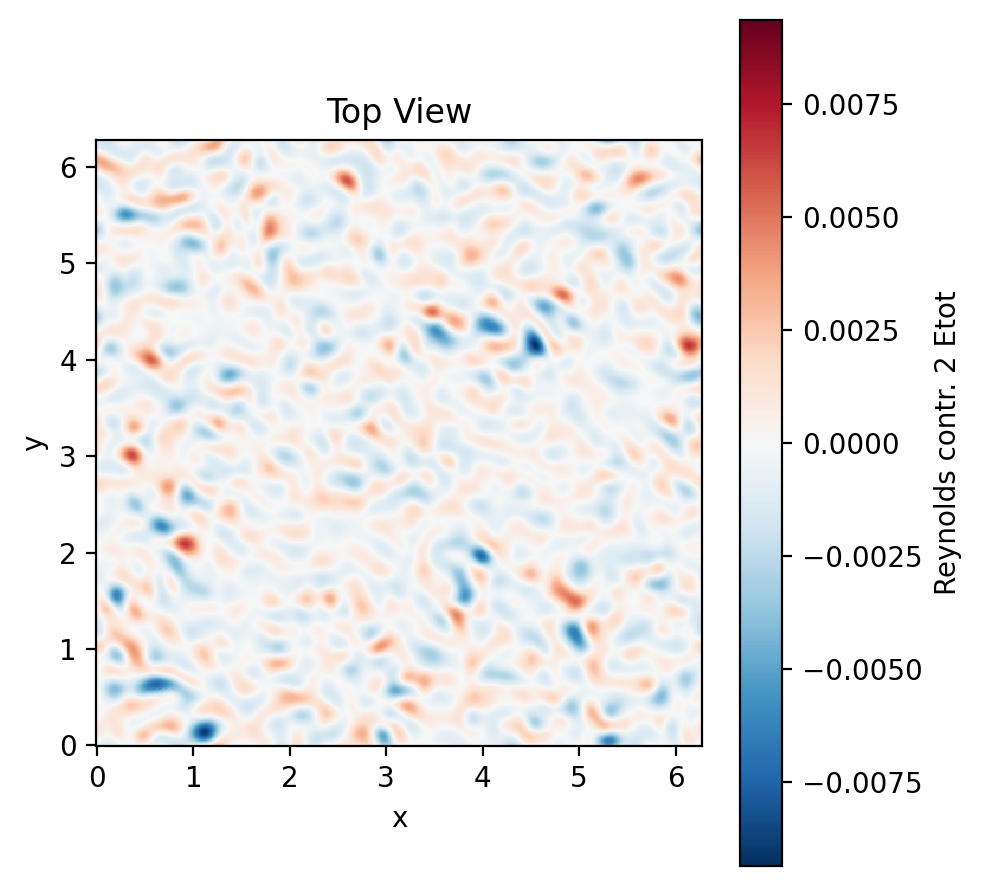

In [12]:
Plot(les.reynolds_etot(zf))()

In [4]:
def diagnose_energy(zf):
    z = les.filter_state(zf)
    zr = zf - z
    integral = lambda f: np.sum(f) * mset.dx * mset.dy
    print("======================== ENERGY DIAGNOSTICS ========================")
    print("            Resolved     |      Unresolved     |    Total")
    epotf = integral(zf.epot())
    epot = integral(z.epot())
    epotr = epotf - epot
    print("Pot: {:9.2e} ({:7.2%}) | {:9.2e} ({:7.2%}) | {:10.3e}".format(
        epot, epot/epotf, epotr, epotr/epotf, epotf))
    ekinf = integral(zf.ekin())
    ekin = integral(z.ekin())
    ekinr = ekinf - ekin
    print("Kin: {:9.2e} ({:7.2%}) | {:9.2e} ({:7.2%}) | {:10.3e}".format(
        ekin, ekin/ekinf, ekinr, ekinr/ekinf, ekinf))
    etotf = integral(zf.etot())
    etot = integral(z.etot())
    etotr = etotf - etot
    print("Tot: {:9.2e} ({:7.2%}) | {:9.2e} ({:7.2%}) | {:10.3e}".format(
        etot, etot/etotf, etotr, etotr/etotf, etotf))
    print("------------------------- ENERGY TRANSFER --------------------------")
    print("            Leonard      |         Clark       |         Reynolds")
    epotl = integral(les.leonard_epot(zf))
    epotc = integral(les.clark_epot(zf))
    epotr = integral(les.reynolds_epot(zf))
    epotf = epotl + epotc + epotr
    print("Pot: {:9.2e} ({:7.2%}) | {:9.2e} ({:7.2%}) | {:10.3e} ({:7.2%})".format(
        epotl, epotl/epotf, epotc, epotc/epotf, epotr, epotr/epotf))
    ekinl = integral(les.leonard_ekin(zf))
    ekinc = integral(les.clark_ekin(zf))
    ekinr = integral(les.reynolds_ekin(zf))
    ekinf = ekinl + ekinc + ekinr
    print("Kin: {:9.2e} ({:7.2%}) | {:9.2e} ({:7.2%}) | {:10.3e} ({:7.2%})".format(
        ekinl, ekinl/ekinf, ekinc, ekinc/ekinf, ekinr, ekinr/ekinf))
    etotl = integral(les.leonard_etot(zf))
    etotc = integral(les.clark_etot(zf))
    etotr = integral(les.reynolds_etot(zf))
    etotf = etotl + etotc + etotr
    print("Tot: {:9.2e} ({:7.2%}) | {:9.2e} ({:7.2%}) | {:10.3e} ({:7.2%})".format(
        etotl, etotl/etotf, etotc, etotc/etotf, etotr, etotr/etotf))
    print("====================================================================")



diagnose_energy(zf)

======================== ENERGY DIAGNOSTICS ========================
            Resolved     |      Unresolved     |    Total
Pot:  1.98e+01 (100.00%) |  5.36e-04 (  0.00%) |  1.976e+01
Kin:  5.34e-01 ( 94.45%) |  3.14e-02 (  5.55%) |  5.655e-01
Tot:  2.03e+01 ( 99.84%) |  3.19e-02 (  0.16%) |  2.033e+01
------------------------- ENERGY TRANSFER --------------------------
            Leonard      |         Clark       |         Reynolds
Pot: -7.02e-19 (  0.00%) | -5.76e-05 ( 73.99%) | -2.024e-05 ( 26.01%)
Kin:  1.02e-04 ( -1.73%) | -1.35e-03 ( 22.82%) | -4.683e-03 ( 78.91%)
Tot:  1.02e-04 ( -1.70%) | -1.41e-03 ( 23.48%) | -4.703e-03 ( 78.23%)


In [6]:
ekl = les.leonard_ekin(zf)
epl = les.leonard_epot(zf)
etl = les.leonard_etot(zf)
print(np.sum(epl))
# Plot(etl)()

-2.0483614804334138e-14


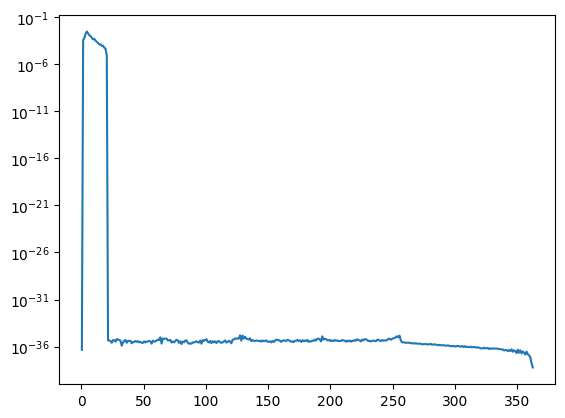

In [7]:
h_filter = les.filter_field(zf.h)
# zc = les.clark_correction(zf)
k, e = h_filter.cpu().spectra_1d()
plt.plot(k, e)
plt.yscale("log")

(1e-12, 0.1)

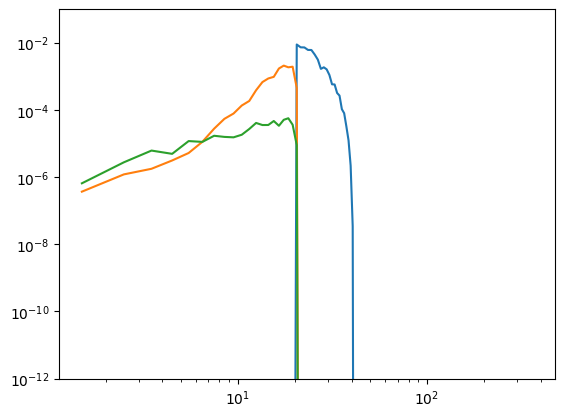

In [12]:
zl = les.leonard_correction(zf) * mset.Ro
zc = les.clark_correction(zf) * mset.Ro
zr = les.reynolds_correction(zf) * mset.Ro

k, ezl = ((zl.u.cpu()) ** 1).spectra_1d()
k, ezc = ((zc.u.cpu()) ** 1).spectra_1d()
k, ezr = ((zr.u.cpu()) ** 1).spectra_1d()
s = slice(1, None)
plt.plot(k[s], ezl[s])
plt.plot(k[s], ezc[s])
plt.plot(k[s], ezr[s])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-12, 1e-1)

(1e-11, 1.0)

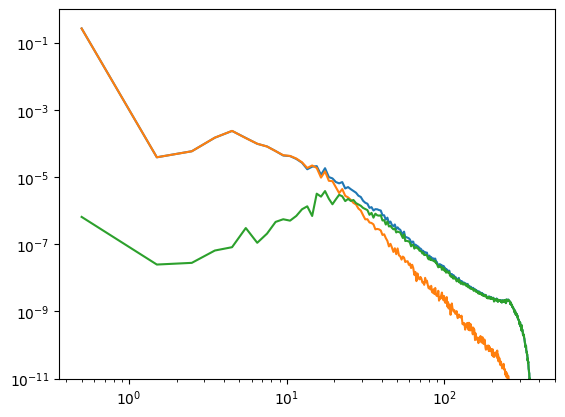

In [18]:
k, er = (etotr.cpu()).spectra_1d()
k, ef = (etotf.cpu()).spectra_1d()
k, e = (etot.cpu()).spectra_1d()
plt.plot(k, ef)
plt.plot(k, e)
plt.plot(k, er)
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-11, 1e0)

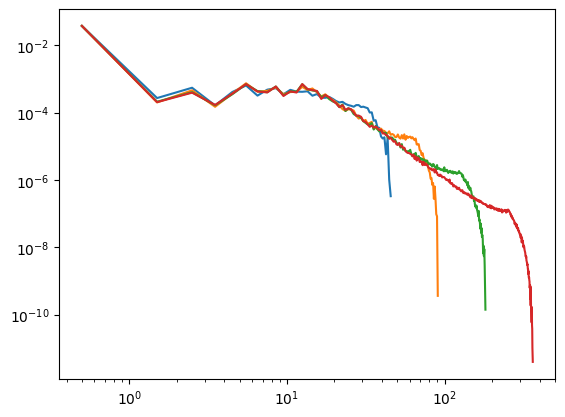

In [59]:
for model in models:
    energy = model.z.ekin().cpu()
    k, e = (energy**(1/2)).spectra_1d()
    plt.plot(k, e)
    # plt.plot(k, k**(-3))
plt.yscale('log')
plt.xscale('log')

In [60]:
model = Model(msets[3], grids[3])
model.z = z_inis[3]
k, spectra = (z_inis[3].ekin().cpu()**(0.5)).spectra_1d()
spectras = [spectra]
for _ in range(100):
    model.run(runlen=0.1)
    k, spectra = (model.z.ekin().cpu()**(0.5)).spectra_1d()
    spectras.append(spectra)

100%|██████████| 51/51 [00:00<00:00, 234.09it/s]


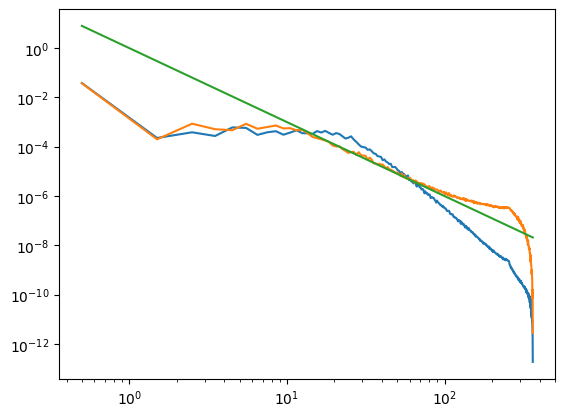

In [67]:
spect = np.array(spectras)
plt.plot(k, spect[0])
plt.plot(k, spect[-1])
plt.plot(k, k**(-3))
plt.yscale('log')
plt.xscale('log')

In [81]:
def filter(z, kmax = 40):
    z_hat = z.fft()
    kx, ky = z.grid.k
    k = (kx**2 + ky**2)**(1/2)
    k_mask = k <= kmax
    z_hat = z_hat * k_mask
    return z_hat.fft()

def leonard(z, kmax=40):
    z_filter = filter(z, kmax)
    uu = z_filter.u * z_filter.u
    uv = z_filter.u * z_filter.v
    uh = z_filter.u * z_filter.h
    vu = z_filter.v * z_filter.u
    vv = z_filter.v * z_filter.v
    vh = z_filter.v * z_filter.h
    
    uuf = filter(uu, kmax)
    uvf = filter(uv, kmax)
    uhf = filter(uh, kmax)
    vuf = filter(vu, kmax)
    vvf = filter(vv, kmax)
    vhf = filter(vh, kmax)

    uu_l = uuf - uu
    uv_l = uvf - uv
    uh_l = uhf - uh
    vu_l = vuf - vu
    vv_l = vvf - vv
    vh_l = vhf - vh

    return uu_l, uv_l, uh_l, vu_l, vv_l, vh_l

In [82]:
uu, uv, uh, vu, vv, vh = leonard(models[3].z)

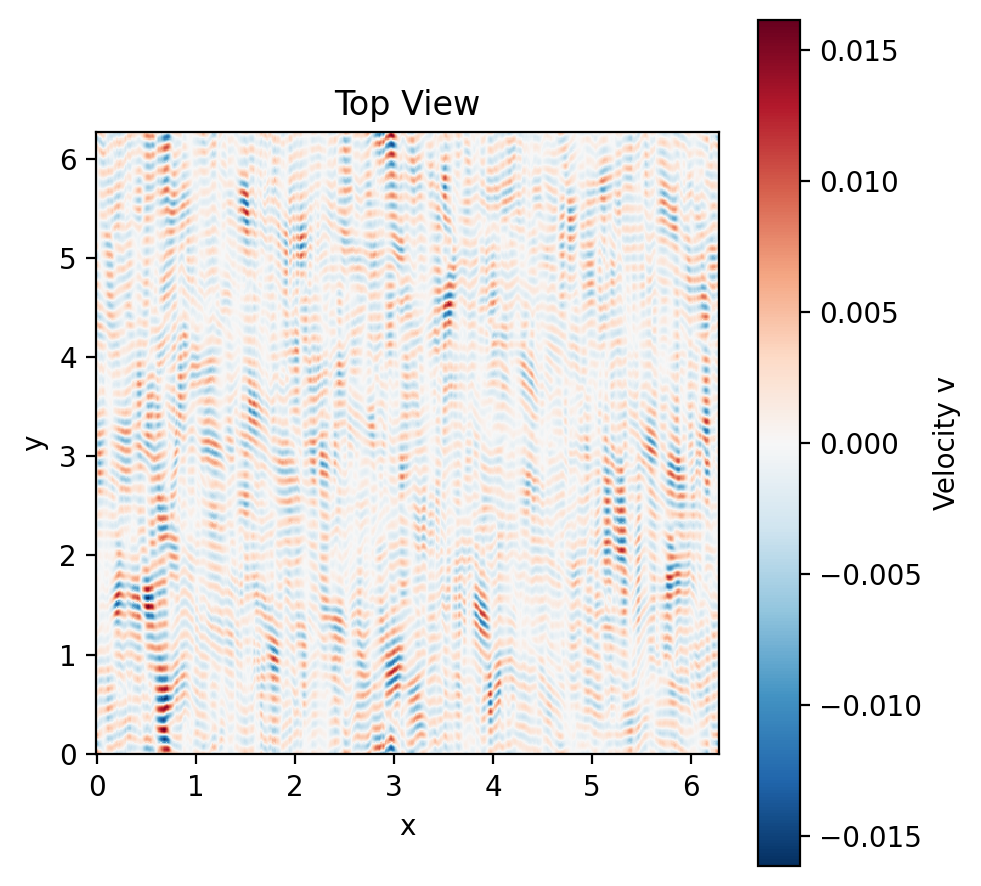

In [93]:
Plot(vh)()

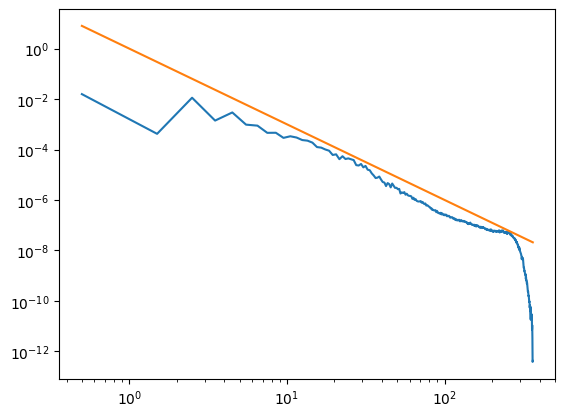

In [30]:
energy = model.z.ekin().cpu()
k, e = (energy**(1/2)).spectra_1d()
plt.plot(k, e)
plt.plot(k, k**(-3))
plt.yscale('log')
plt.xscale('log')

In [22]:
np.min(energy)

array(9.78621006e-09)